In [1]:
!pip install --upgrade pip -q
!pip install nlpaug -q

In [2]:
# Importing necessary libraries and fixing seed

import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from keras import backend as K

from kaggle_datasets import KaggleDatasets
import transformers
from tokenizers import BertWordPieceTokenizer
from sklearn.model_selection import train_test_split

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw

seed = 128

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


/kaggle/input/sibur20-naming-data/sample_submission.csv
/kaggle/input/sibur20-naming-data/train.csv
/kaggle/input/sibur20-naming-data/test.csv
/kaggle/input/sibur20-naming-data/baseline_submission.csv


In [3]:
train = pd.read_csv('/kaggle/input/sibur20-naming-data/train.csv', index_col="pair_id")
test = pd.read_csv('/kaggle/input/sibur20-naming-data/test.csv', index_col="pair_id")
sample_submission = pd.read_csv('/kaggle/input/sibur20-naming-data/sample_submission.csv', index_col="pair_id")

In [4]:
# We were using train_test_split cause CV didn't bring desired stability, so the usual split was enough

local_train, local_test  = train_test_split(train,
                                            test_size=0.25, 
                                            random_state=seed,
                                            stratify=train['is_duplicate'])

In [5]:
# The objective is a binary classification with a very imbalanced dataset

local_train['is_duplicate'].value_counts(normalize=True)

0    0.992653
1    0.007347
Name: is_duplicate, dtype: float64

In [6]:
# In this competitions we had to determine if a pair of names belong to the same company
# You can see an example of a company with the same names

train_text = local_train[local_train.is_duplicate==1].values.tolist()
train_text[3][:2]

['Bridgestone De Mexico S.A. De C.V.',
 'Bridgestone Do Brasil Industria & Comercio Ltda']

In [7]:
# Creating few augmentations to increase the number of class '1' in the dataset

aug1 = nac.RandomCharAug(action="delete")
aug2 = nac.RandomCharAug(action="swap")
aug3 = naw.RandomWordAug(action="delete")
aug4 = naw.RandomWordAug(action="swap")

In [8]:
# Example of using our augmentations 

print('Original sentence:\t\t', train_text[3][1])
print('Sentence with deleted letters:\t', aug1.augment(train_text[3][1]))
print('Sentence with swapped letters:\t', aug2.augment(train_text[3][1]))
print('Sentence with deleted words:\t', aug3.augment(train_text[3][1]))
print('Sentence with swapped words:\t', aug4.augment(train_text[3][1]))

Original sentence:		 Bridgestone Do Brasil Industria & Comercio Ltda
Sentence with deleted letters:	 Bridgestone Do Brasil Indutra & Comercio tda
Sentence with swapped letters:	 Bridgetonse Do Brasil Industria & Comercio Tlda
Sentence with deleted words:	 Bridgestone Do & Comercio Ltda
Sentence with swapped words:	 Do bridgestone Brasil Industria & Ltda Comercio


In [9]:
# Creating nested lists with augmentation

aug_texts = []

for i in tqdm(range(len(train_text))):
    aug_texts.append(aug1.augment(train_text[i][:2]))
    aug_texts.append(aug2.augment(train_text[i][:2]))
    aug_texts.append(aug3.augment(train_text[i][:2]))
    aug_texts.append(aug4.augment(train_text[i][:2]))
    
aug_texts[:8]

100%|██████████| 2743/2743 [00:02<00:00, 1306.91it/s]


[['Bdp Iernationl Basf Imp.', 'Basf Japa Ltd.'],
 ['Bdp Ntiernatinoal Basf Imp.', 'Basf Jaapn Ltd.'],
 ['Bdp International Imp.', 'Basf Japan.'],
 ['Bdp Basf International Imp.', 'Japan basf Ltd.'],
 ['Total Bitumen GbH', 'TOTL Poska Sp. z o. o.'],
 ['Toatl Bitumen GmbH', 'TOTLA Polksa Sp. z o. o.'],
 ['Total Bitumen', 'TOTAL. z o. o.'],
 ['Bitumen total GmbH', 'TOTAL Polska Sp. o z o..']]

In [10]:
# Making dataset similar to our initial set from augmentations

aug_train = pd.DataFrame(columns=['name_1', 'name_2'], data=aug_texts)
aug_train['is_duplicate'] = 1

print('local_train shape', local_train.shape)
print('aug_train shape', aug_train.shape)

local_train shape (373364, 3)
aug_train shape (10972, 3)


In [11]:
# Concating our augmented dataset with train set

local_train_aug = pd.concat([local_train, aug_train])
local_train_aug['is_duplicate'].value_counts(normalize=True)

0    0.964315
1    0.035685
Name: is_duplicate, dtype: float64

In [12]:
X_train = local_train_aug.drop('is_duplicate', axis=1)
X_test = local_test.drop('is_duplicate', axis=1)

y_train = local_train_aug['is_duplicate']
y_test = local_test['is_duplicate']

In [13]:
# We'll use undersampling to make our dataset even more balanced

from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=seed, sampling_strategy=0.2)

In [14]:
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
print(X_train.shape, X_train_res.shape)

(384336, 2) (82290, 2)


In [15]:
# This value counts is much better than our initial

y_train_res.value_counts(normalize=True)

0    0.833333
1    0.166667
Name: is_duplicate, dtype: float64

In [16]:
# Function for tokenization our sentences

def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []

    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk_1 = texts.name_1.values[i:i+chunk_size]
        text_chunk_2 = texts.name_2.values[i:i+chunk_size]

        encs = tokenizer.encode_batch(list(zip(text_chunk_1, text_chunk_2)))
        all_ids.extend([enc.ids for enc in encs])
        
    return np.array(all_ids)

In [17]:
# We tried to use custom F1 loss, but the results didn't go better, so we're using classic binary_crossentropy

def macro_soft_f1(y, y_hat):

    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1
    
    macro_cost = tf.reduce_mean(cost)
    
    return macro_cost

In [18]:
# Competition metric

def f1(y_true, y_pred):
    
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [19]:
# We added a Dense layer with 512 neurons + AUC to validate result by few metrics

def build_model(transformer, max_len=512):

    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    x = tf.keras.layers.Dense(512, activation='elu')(cls_token)
    x = Dropout(0.2)(x)
    out = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=5e-5), loss='binary_crossentropy', metrics=[f1,'AUC'])
    
    return model

In [20]:
# Making TPU config

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()
    
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [21]:
# Creating model config based on distilbert

AUTO = tf.data.experimental.AUTOTUNE

GCS_DS_PATH = KaggleDatasets().get_gcs_path()

EPOCHS = 6
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 100
MODEL = 'distilbert-base-uncased'

In [22]:
# Creating huggingface tokenizer and saving it locally

tokenizer = transformers.DistilBertTokenizer.from_pretrained(MODEL)
tokenizer.save_pretrained('.')
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)

In [23]:
X_train_enc = fast_encode(X_train_res, fast_tokenizer, maxlen=MAX_LEN)
X_test_enc = fast_encode(X_test, fast_tokenizer, maxlen=MAX_LEN)
test_enc = fast_encode(test, fast_tokenizer, maxlen=MAX_LEN)

100%|██████████| 834/834 [00:11<00:00, 74.11it/s]


In [24]:
X_train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_train_enc, y_train_res))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

X_test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((X_test_enc, y_test))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(test_enc)
    .batch(BATCH_SIZE)
)

In [25]:
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained(MODEL)
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 100)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 100, 768),)       66362880  
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 512)               393728    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 66,757,121
Trainable params: 66,757,121
Non-trainable params: 0
________________________________________________

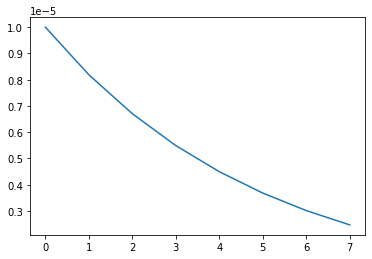

In [26]:
# Now let's create a learning rate scheduler and check how it works

epochs = [i for i in range(8)]

def visualise_scheduler(lr, epoch):
    return lr*(np.exp(-0.2)**epoch)

sns.lineplot(x=epochs, y = visualise_scheduler(lr=1e-5, epoch=epochs))
plt.show()

In [27]:
# Tensorflow implementation of the scheduler

def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.2)

callback = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

In [28]:
n_steps = X_train_res.shape[0] // BATCH_SIZE

train_history = model.fit(
    X_train_dataset,
    steps_per_epoch=n_steps,
    verbose=True,
    validation_data=X_test_dataset,
    epochs=EPOCHS,
    callbacks = callback
)

Epoch 1/6
642/642 [==============================] - 78s 121ms/step - loss: 0.0645 - f1: 0.1602 - auc: 0.9940 - val_loss: 0.2826 - val_f1: 0.0628 - val_auc: 0.9628 - lr: 4.0937e-05
Epoch 2/6
642/642 [==============================] - 66s 103ms/step - loss: 0.0293 - f1: 0.2192 - auc: 0.9978 - val_loss: 0.1129 - val_f1: 0.0931 - val_auc: 0.9975 - lr: 3.3516e-05
Epoch 3/6
642/642 [==============================] - 67s 104ms/step - loss: 0.0177 - f1: 0.2320 - auc: 0.9991 - val_loss: 0.2238 - val_f1: 0.0756 - val_auc: 0.9976 - lr: 2.7441e-05
Epoch 4/6
642/642 [==============================] - 67s 105ms/step - loss: 0.0126 - f1: 0.2375 - auc: 0.9993 - val_loss: 0.0978 - val_f1: 0.0940 - val_auc: 0.9968 - lr: 2.2466e-05
Epoch 5/6
642/642 [==============================] - 67s 104ms/step - loss: 0.0098 - f1: 0.2399 - auc: 0.9994 - val_loss: 0.1043 - val_f1: 0.0963 - val_auc: 0.9952 - lr: 1.8394e-05
Epoch 6/6
642/642 [==============================] - 67s 104ms/step - loss: 0.0084 - f1: 0.2419

In [29]:
def visualize_results(trained):
    
    plt.plot(trained.history['f1'])
    plt.plot(trained.history['val_f1'])
    
    plt.title('F1')
    plt.ylabel('F1')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    
    plt.show()

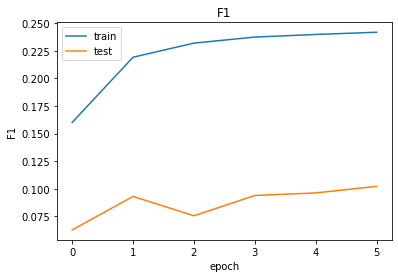

In [30]:
# As you can see, the loss plot looks good and not overfitted 

visualize_results(train_history)

In [31]:
# Now model is ready for the final prediction

preds = model.predict(test_dataset, verbose=1)

1667/1667 [==============================] - 38s 23ms/step


In [32]:
# Making and saving submission

sample_submission['is_duplicate'] = np.round(preds.flatten()).astype(int)
sample_submission.to_csv('submission.csv')

sample_submission['is_duplicate'].value_counts(normalize=True)

0    0.981519
1    0.018481
Name: is_duplicate, dtype: float64